<a href="https://colab.research.google.com/github/ericdnbn/nn_image_classifier_pneumonia/blob/main/Eric%E2%80%93nn_classifier_colab_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, shutil
import time
import matplotlib.pyplot as plt
import scipy
import numpy as np
from PIL import Image
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
train_dir = 'chest_xray/train'
val_dir = 'chest_xray/val'
test_dir = 'chest_xray/test/' 

In [3]:
train_normal_dir = os.path.join(train_dir, 'NORMAL')
train_pneu_dir = os.path.join(train_dir, 'PNEUMONIA')

test_normal_dir = os.path.join(test_dir, 'NORMAL')
test_pneu_dir = os.path.join(test_dir, 'PNEUMONIA')

val_normal_dir = os.path.join(val_dir, 'NORMAL')
val_pneu_dir = os.path.join(val_dir, 'PNEUMONIA')

In [4]:
train_normal_dir

'chest_xray/train/NORMAL'

In [5]:
len(os.listdir(train_normal_dir))

1341

In [6]:
# get all the data in the directory split/train (542 images), and reshape them
arg_dict = {'target_size':(100, 100), 
            'color_mode':'grayscale', 
            'batch_size':50}

train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(train_dir, **arg_dict)


# get all the data in the directory split/test (180 images), and reshape them
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_dir, **arg_dict) 

# get all the data in the directory split/validation (200 images), and reshape them
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(val_dir, **arg_dict)


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [7]:
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [8]:
train_images[0]

array([[[0.15294118],
        [0.21960786],
        [0.98823535],
        ...,
        [0.0509804 ],
        [0.04705883],
        [0.        ]],

       [[0.15686275],
        [0.21568629],
        [0.9960785 ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.14901961],
        [0.227451  ],
        [0.9843138 ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       ...,

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.01176471],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.01176471]]], dtype=float32)

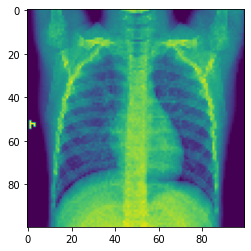

In [9]:
plt.imshow(train_images[3])

In [10]:
train_images.shape[0]

50

In [11]:
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 50
Number of testing samples: 50
Number of validation samples: 16
train_images shape: (50, 100, 100, 1)
train_labels shape: (50, 2)
test_images shape: (50, 100, 100, 1)
test_labels shape: (50, 2)
val_images shape: (16, 100, 100, 1)
val_labels shape: (16, 2)


In [12]:
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

(50, 10000)
(50, 10000)
(16, 10000)


In [13]:
train_y = np.reshape(train_labels[:,0], (50,1))
test_y = np.reshape(test_labels[:,0], (50,1))
val_y = np.reshape(val_labels[:,0], (16,1))

print(train_y)
print(test_y)
print(val_y)

[[0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]]
[[1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]]
[[0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]]


In [14]:
# First Simple Model
model = models.Sequential()

In [15]:
model.add(layers.Dense(32, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(1, activation='sigmoid'))

In [16]:
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy', 'Recall'])

In [17]:
history = model.fit(train_img, 
                     train_y,
                     epochs=50,
                     batch_size=10,
                     validation_data=(val_img, val_y))

Epoch 1/50
5/5 [==============================] - 0s 96ms/step - loss: 0.6856 - accuracy: 0.7000 - recall: 0.1250 - val_loss: 0.6919 - val_accuracy: 0.5000 - val_recall: 1.0000
Epoch 2/50
5/5 [==============================] - 0s 28ms/step - loss: 0.6986 - accuracy: 0.5600 - recall: 0.1250 - val_loss: 0.7207 - val_accuracy: 0.5000 - val_recall: 0.0000e+00
Epoch 3/50
5/5 [==============================] - 0s 30ms/step - loss: 0.6235 - accuracy: 0.6800 - recall: 0.0000e+00 - val_loss: 0.6922 - val_accuracy: 0.5000 - val_recall: 0.0000e+00
Epoch 4/50
5/5 [==============================] - 0s 23ms/step - loss: 0.6499 - accuracy: 0.6800 - recall: 0.0000e+00 - val_loss: 0.7209 - val_accuracy: 0.5000 - val_recall: 0.0000e+00
Epoch 5/50
5/5 [==============================] - 0s 33ms/step - loss: 0.6057 - accuracy: 0.6800 - recall: 0.0000e+00 - val_loss: 0.8123 - val_accuracy: 0.5000 - val_recall: 0.0000e+00
Epoch 6/50
5/5 [==============================] - 0s 17ms/step - loss: 0.6115 - accurac

5/5 [==============================] - 0s 15ms/step - loss: 0.3253 - accuracy: 0.9200 - recall: 0.7500 - val_loss: 0.9012 - val_accuracy: 0.5000 - val_recall: 0.0000e+00
Epoch 47/50
5/5 [==============================] - 0s 12ms/step - loss: 0.3172 - accuracy: 0.9200 - recall: 0.7500 - val_loss: 1.0752 - val_accuracy: 0.5000 - val_recall: 0.0000e+00
Epoch 48/50
5/5 [==============================] - 0s 14ms/step - loss: 0.3348 - accuracy: 0.8800 - recall: 0.6250 - val_loss: 0.9234 - val_accuracy: 0.5000 - val_recall: 0.0000e+00
Epoch 49/50
5/5 [==============================] - 0s 9ms/step - loss: 0.2983 - accuracy: 0.9000 - recall: 0.6875 - val_loss: 0.6613 - val_accuracy: 0.6250 - val_recall: 0.2500
Epoch 50/50
5/5 [==============================] - 0s 13ms/step - loss: 0.3261 - accuracy: 0.9000 - recall: 0.6875 - val_loss: 0.6184 - val_accuracy: 0.7500 - val_recall: 0.6250


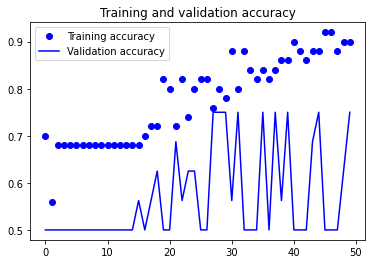

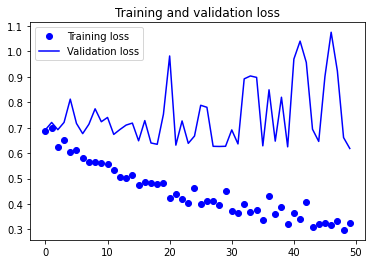

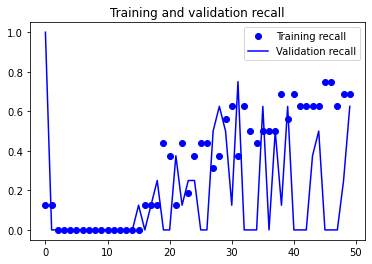

In [18]:

import matplotlib.pyplot as plt
%matplotlib inline 

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
recall = history.history['recall']
val_recall = history.history['val_recall']

epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()
plt.plot(epochs, recall, 'bo', label='Training recall')
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.legend()
plt.show()

In [19]:
results_train = model.evaluate(train_img, train_y)

2/2 [==============================] - 0s 2ms/step - loss: 0.3739 - accuracy: 0.9600 - recall: 1.0000


In [20]:
results_train

[0.3739169239997864, 0.9599999785423279, 1.0]

In [21]:
results_test = model.evaluate(test_img, test_y)

2/2 [==============================] - 0s 1ms/step - loss: 0.6391 - accuracy: 0.6200 - recall: 0.3462


In [22]:
results_test

[0.6390889883041382, 0.6200000047683716, 0.3461538553237915]

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [24]:
preds = (model.predict(train_img) > 0.5).astype('int32')

cm = confusion_matrix(train_y, preds)

In [25]:
cm

array([[32,  2],
       [ 0, 16]])

In [26]:
cmd = ConfusionMatrixDisplay(cm, display_labels=['Nomral', 'Pneumonia'])

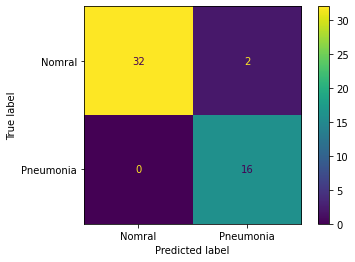

In [27]:
cmd.plot()

In [28]:
from sklearn.utils import class_weight

# Calculate floats/raw class weights
class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(train_generator.classes), 
                train_generator.classes)

# Convert to dict for .fit(class_weight= ) param
nn_class_weights = {0:class_weights[0],
                    1:class_weights[1]}

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [29]:
def preprocessing_dense_data(train_directory=train_dir,
                             test_directory=test_dir,
                             val_directory=val_dir,
                             ts_tuple=(256,256), 
                             color='grayscale', 
                             batch_size=None):

    
    arg_dict = {'target_size':ts_tuple, 
                'color_mode':color, 
                'batch_size':batch_size}

    train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(train_dir, **arg_dict)


    # get all the data in the directory split/test (180 images), and reshape them
    test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_dir, **arg_dict) 

    # get all the data in the directory split/validation (200 images), and reshape them
    val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(val_dir, **arg_dict)
    
    
    train_images, train_labels = next(train_generator)
    
    test_images, test_labels = next(test_generator)
    
    val_images, val_labels = next(val_generator)
    
    
    X_train = train_images.reshape(train_images.shape[0], -1)
    
    X_test = test_images.reshape(test_images.shape[0], -1)
    
    X_val = val_images.reshape(val_images.shape[0], -1)
    
    
    y_train = np.reshape(train_labels[:,0], (train_images.shape[0],1))
    
    y_test = np.reshape(test_labels[:,0], (test_images.shape[0],1))
    
    y_val = np.reshape(val_labels[:,0], (val_images.shape[0],1))
    
    
    return X_train, X_test, X_val, y_train, y_test, y_val
    
    


In [30]:
X_train, X_test, X_val, y_train, y_test, y_val = preprocessing_dense_data(batch_size=200)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [31]:
model2 = models.Sequential()

In [32]:
model2.add(layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
model2.add(layers.Dense(16, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))

In [33]:
model2.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy', 'Recall'])

In [34]:
history2 = model2.fit(X_train, 
                     y_train,
                     epochs=50,
                     batch_size=10,
                     validation_data=(X_val, y_val))

Epoch 1/50
20/20 [==============================] - 1s 34ms/step - loss: 0.7097 - accuracy: 0.6750 - recall: 0.0755 - val_loss: 0.7137 - val_accuracy: 0.5000 - val_recall: 0.0000e+00
Epoch 2/50
20/20 [==============================] - 0s 18ms/step - loss: 0.5699 - accuracy: 0.7300 - recall: 0.0566 - val_loss: 1.2233 - val_accuracy: 0.5000 - val_recall: 0.0000e+00
Epoch 3/50
20/20 [==============================] - 0s 21ms/step - loss: 0.5780 - accuracy: 0.7150 - recall: 0.0943 - val_loss: 0.6702 - val_accuracy: 0.5000 - val_recall: 0.0000e+00
Epoch 4/50
20/20 [==============================] - 0s 17ms/step - loss: 0.4926 - accuracy: 0.7650 - recall: 0.1321 - val_loss: 0.7767 - val_accuracy: 0.5000 - val_recall: 0.0000e+00
Epoch 5/50
20/20 [==============================] - 0s 20ms/step - loss: 0.5702 - accuracy: 0.7300 - recall: 0.1509 - val_loss: 0.6597 - val_accuracy: 0.6250 - val_recall: 1.0000
Epoch 6/50
20/20 [==============================] - 0s 15ms/step - loss: 0.4516 - accurac

20/20 [==============================] - 0s 24ms/step - loss: 0.1705 - accuracy: 0.9700 - recall: 0.9434 - val_loss: 0.6354 - val_accuracy: 0.6875 - val_recall: 0.3750
Epoch 47/50
20/20 [==============================] - 0s 15ms/step - loss: 0.1496 - accuracy: 0.9850 - recall: 0.9623 - val_loss: 0.7231 - val_accuracy: 0.6250 - val_recall: 0.2500
Epoch 48/50
20/20 [==============================] - 1s 26ms/step - loss: 0.1547 - accuracy: 0.9750 - recall: 0.9434 - val_loss: 0.4079 - val_accuracy: 0.8750 - val_recall: 0.7500
Epoch 49/50
20/20 [==============================] - 0s 18ms/step - loss: 0.1327 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 1.0213 - val_accuracy: 0.6250 - val_recall: 0.2500
Epoch 50/50
20/20 [==============================] - 0s 15ms/step - loss: 0.1800 - accuracy: 0.9550 - recall: 0.9434 - val_loss: 0.4400 - val_accuracy: 0.8750 - val_recall: 0.7500


In [35]:
def visualize_nn(history, model, X, y_true):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    recall = history.history['recall']
    val_recall = history.history['val_recall']

    epochs = range(len(acc))
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.figure()
    plt.plot(epochs, recall, 'bo', label='Training recall')
    plt.plot(epochs, val_recall, 'b', label='Validation recall')
    plt.title('Training and validation recall')
    plt.legend()
    plt.show()
    
    
    preds = (model.predict(X) > 0.5).astype('int32')

    cm = confusion_matrix(y_true, preds)
    
    cmd = ConfusionMatrixDisplay(cm, display_labels=['Normal', 'Pneumonia'])
    
    cmd.plot();

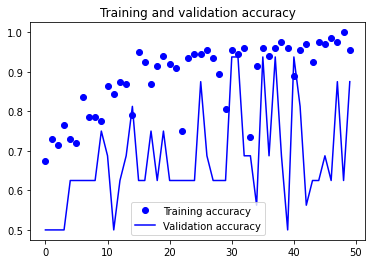

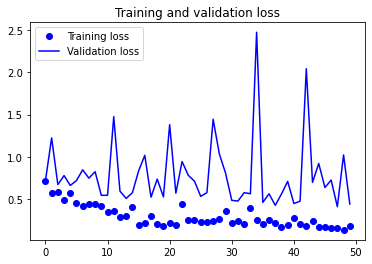

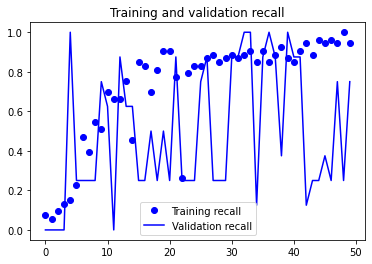

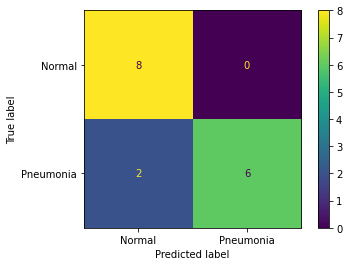

In [36]:
visualize_nn(history2, model2, X_val, y_val)

In [40]:
def nn_model(dense_list, 
             train_directory=train_dir,
             test_directory=test_dir,
             val_directory=val_dir,
             ts_tuple=(256,256), 
             color='grayscale',
             batch_size=None,
             input_activation='relu',
             layer_activation='relu',
             output_activation='sigmoid',
             l2_rate=0.01,
             optimizer='sgd',
             loss='binary_crossentropy',
             metrics=['accuracy', 'Recall'],
             epochs=100,
             bs=10):
    
    X_train, X_test, X_val, y_train, y_test, y_val = preprocessing_dense_data(batch_size=batch_size)
    
    nn_model = models.Sequential()
    
    
    nn_model.add(layers.Dense(64, activation=input_activation, input_shape=(X_train.shape[1],)))
    
    for i, val in enumerate(dense_list):
        nn_model.add(layers.Dense(int(dense_list[i]), 
                                  activation=layer_activation,
                                  kernel_regularizer=l2(l2=l2_rate)))
        
        
    nn_model.add(layers.Dense(1, activation=output_activation))
        
    nn_model.compile(optimizer=optimizer,
                     loss=loss,
                     metrics=metrics)
    
    
    hist = nn_model.fit(X_train, y_train, epochs=epochs, batch_size=bs, validation_data=(X_val, y_val))
    
    visualize_nn(history, nn_model, X_val, y_val)
    

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Epoch 1/100
50/50 [==============================] - 4s 82ms/step - loss: 1.3632 - accuracy: 0.7080 - recall: 0.0154 - val_loss: 1.4086 - val_accuracy: 0.5000 - val_recall: 0.0000e+00
Epoch 2/100
50/50 [==============================] - 2s 30ms/step - loss: 1.2005 - accuracy: 0.7320 - recall: 0.0231 - val_loss: 1.3755 - val_accuracy: 0.5000 - val_recall: 0.0000e+00
Epoch 3/100
50/50 [==============================] - 2s 33ms/step - loss: 1.1558 - accuracy: 0.7400 - recall: 0.0000e+00 - val_loss: 1.4081 - val_accuracy: 0.5000 - val_recall: 0.0000e+00
Epoch 4/100
50/50 [==============================] - 2s 39ms/step - loss: 1.0924 - accuracy: 0.7400 - recall: 0.0000e+00 - val_loss: 1.3437 - val_accuracy: 0.5000 - val_recall: 0.0000e+00
Epoch 5/100
50/50 [==============================] - 2s 46ms/step - loss: 1.0155 - accuracy: 0.7720 - recall: 0.1308 - val_loss: 1.23

50/50 [==============================] - 2s 31ms/step - loss: 0.3564 - accuracy: 0.9840 - recall: 0.9692 - val_loss: 0.8187 - val_accuracy: 0.8125 - val_recall: 0.6250
Epoch 46/100
50/50 [==============================] - 2s 37ms/step - loss: 0.3814 - accuracy: 0.9720 - recall: 0.9615 - val_loss: 1.1745 - val_accuracy: 0.6875 - val_recall: 0.3750
Epoch 47/100
50/50 [==============================] - 2s 34ms/step - loss: 0.3456 - accuracy: 0.9780 - recall: 0.9615 - val_loss: 0.5032 - val_accuracy: 0.9375 - val_recall: 0.8750
Epoch 48/100
50/50 [==============================] - 1s 24ms/step - loss: 0.3421 - accuracy: 0.9820 - recall: 0.9769 - val_loss: 2.4210 - val_accuracy: 0.5625 - val_recall: 0.1250
Epoch 49/100
50/50 [==============================] - 2s 31ms/step - loss: 0.3393 - accuracy: 0.9820 - recall: 0.9538 - val_loss: 0.5299 - val_accuracy: 0.9375 - val_recall: 1.0000
Epoch 50/100
50/50 [==============================] - 1s 22ms/step - loss: 0.4079 - accuracy: 0.9600 - recal

50/50 [==============================] - 1s 21ms/step - loss: 0.1469 - accuracy: 0.9960 - recall: 1.0000 - val_loss: 0.7563 - val_accuracy: 0.7500 - val_recall: 0.5000
Epoch 91/100
50/50 [==============================] - 1s 26ms/step - loss: 0.1445 - accuracy: 0.9960 - recall: 1.0000 - val_loss: 0.6204 - val_accuracy: 0.8125 - val_recall: 0.6250
Epoch 92/100
50/50 [==============================] - 1s 29ms/step - loss: 0.1419 - accuracy: 0.9960 - recall: 1.0000 - val_loss: 0.5592 - val_accuracy: 0.8125 - val_recall: 0.6250
Epoch 93/100
50/50 [==============================] - 1s 26ms/step - loss: 0.1393 - accuracy: 0.9960 - recall: 1.0000 - val_loss: 0.6227 - val_accuracy: 0.8125 - val_recall: 0.6250
Epoch 94/100
50/50 [==============================] - 1s 27ms/step - loss: 0.1384 - accuracy: 0.9960 - recall: 1.0000 - val_loss: 0.7849 - val_accuracy: 0.7500 - val_recall: 0.5000
Epoch 95/100
50/50 [==============================] - 2s 35ms/step - loss: 0.1351 - accuracy: 0.9960 - recal

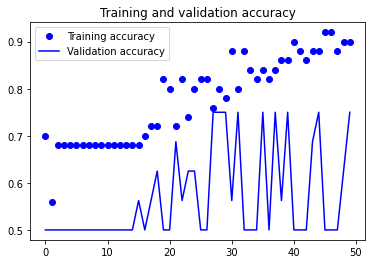

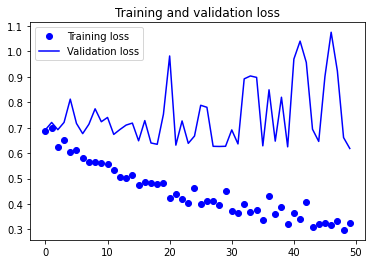

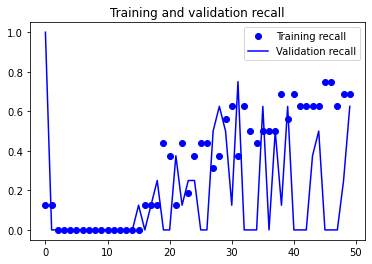

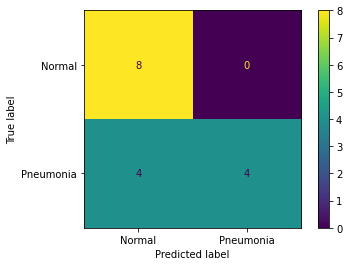

In [41]:
nn_model([32,16],batch_size=500)

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(filters=32,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))